# Geoapify Places 4 Cities

In [1]:
# Dependencies
from census import Census
import hvplot.pandas
import time
import requests
import json
import pandas as pd
import numpy as np
from scipy.stats import linregress
from matplotlib import pyplot as plt

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

# Import the API key
from config_key import geoapify_key
from config_key import census_key

In [2]:
# Create an instance of the Census library
c = Census(
    census_key, 
    year=2021
)

# Run Census Search to retrieve data on all zip codes (2021 ACS5 Census)
census_data = c.acs5.get(
    (
        "B01003_001E",
        "B17001_002E"
    ),
    {'for': 'zip code tabulation area:*'}
)

# Convert to DataFrame
census_df = pd.DataFrame(census_data)

# Column renaming
census_df = census_df.rename(
    columns = {
        "B01003_001E": "Population",
        "B17001_002E": "Poverty Count",
        "zip code tabulation area": "Zipcode",
    }
)

In [3]:
# Display the dataframe
census_df

,Population,Poverty Count,Zipcode
0,17126.0,11302.0,00601
1,37895.0,17121.0,00602
2,49136.0,23617.0,00603
3,5751.0,3139.0,00606
4,26153.0,11640.0,00610
...,...,...,...
33769,13.0,0.0,99923
33770,917.0,182.0,99925
33771,1445.0,252.0,99926
33772,11.0,0.0,99927


In [4]:
# Create lists for cities and places
cities = ["Bronx, NY","Napa, CA", "Victorville, CA","San Francisco, CA"]

places = ["512ffe11e13a7852c059ed90ac0d5f6c4440f00101f9010ce3930000000000c00205",
          "512f63af1c46925ec0597f784c9308264340f00101f90177b4010000000000c00208",
          "512461df4ea2525dc0594fd5f3249f444140f00101f901e0b4010000000000c00208",
          "513a596abddf9a5ec05913dd6921b7e34240f00101f90160b5010000000000c00208"]

# Create empty lists for rows and responses
rows = []
responses = []

In [5]:
# Run the for loop to find supermarkets within a 10 mile radius
for place in places:
    filters = f"place:{place}"
    categories = "commercial.supermarket"
    params = {
        "categories":categories,
        "apiKey":geoapify_key,
        "filter":filters #,
    }

    # Set base URL
    base_url = "https://api.geoapify.com/v2/places"

    # Make an API request using the params dictionary
    response = requests.get(base_url,params=params)

    # convert response to JSON
    supermarket_data = response.json()

    # print the response url (avoid doing for public github repos in order to avoid exposing key)
    print(response.url)
    responses.append(supermarket_data)

https://api.geoapify.com/v2/places?categories=commercial.supermarket&apiKey=bf8e20276a9741e3b5a704ce3a508735&filter=place%3A512ffe11e13a7852c059ed90ac0d5f6c4440f00101f9010ce3930000000000c00205
https://api.geoapify.com/v2/places?categories=commercial.supermarket&apiKey=bf8e20276a9741e3b5a704ce3a508735&filter=place%3A512f63af1c46925ec0597f784c9308264340f00101f90177b4010000000000c00208
https://api.geoapify.com/v2/places?categories=commercial.supermarket&apiKey=bf8e20276a9741e3b5a704ce3a508735&filter=place%3A512461df4ea2525dc0594fd5f3249f444140f00101f901e0b4010000000000c00208
https://api.geoapify.com/v2/places?categories=commercial.supermarket&apiKey=bf8e20276a9741e3b5a704ce3a508735&filter=place%3A513a596abddf9a5ec05913dd6921b7e34240f00101f90160b5010000000000c00208


In [6]:
# Initialize the for loop
for elephant in responses:
    # Extracting 'features' and 'properties' from JSON
    features = elephant.get("features", [])
    for feature in features: 
        properties = feature.get("properties",{})
        # Extract relevant information
        name = properties.get("name") 
        place_id = properties.get("place_id")
        lat = properties.get("lat") 
        lon = properties.get("lon") # Append data to the list
        postcode = properties.get("postcode")
        radius = properties.get("radius")
        city = properties.get("city")
        county = properties.get("county")
        rows.append({"Name": name, "City": city, "Zipcode": postcode, "Latitude": lat, "Longitude": lon,"Place Id": place_id, "county":county}) 
    print(len(rows))

20
32
42
62


In [7]:
# Create a DataFrame 
supermarket_df = pd.DataFrame(rows)

# Display the value count for supermarkets in each city
supermarket_df["City"].value_counts()

City
New York         20
San Francisco    20
Napa             12
Victorville      10
Name: count, dtype: int64

In [8]:
# Display the supermarket dataframe
supermarket_df

,Name,City,Zipcode,Latitude,Longitude,Place Id,county
0,Key Food Supermarket,New York,10463,40.885384,-73.909268,5151521674317a52c059d7034f4354714440f00103f901...,None
1,C-Town,New York,10460,40.837478,-73.887916,5182a6ca9cd37852c059ef1d2378326b4440f00103f901...,None
2,Western Beef,New York,10451,40.812692,-73.926424,51454eba884a7b52c059baa9424706684440f00103f901...,None
3,Food Bazaar,New York,10451,40.822071,-73.930285,51d1fd41c9897b52c059350d2d9b39694440f00103f901...,None
4,ALDI,New York,10463,40.877692,-73.904815,51959c137be87952c059c54b753458704440f00103f901...,None
...,...,...,...,...,...,...,...
57,Whole Foods Market,San Francisco,94107,37.764330,-122.402724,51f5d43439c6995ec059e211138fd5e14240f00103f901...,None
58,H Mart,San Francisco,94132,37.710398,-122.467650,515dfe43faed9d5ec0599d33d44feeda4240f00103f901...,None
59,Gus's Community Market,San Francisco,94166,37.752838,-122.503584,517eb262b83aa05ec0598e3ab5ff5ce04240f00103f901...,None
60,Safeway,San Francisco,94118,37.774613,-122.465134,517d9065c1c49d5ec059222e9d8026e34240f00103f901...,None


In [9]:
# Create the map with the supermarkets
supermarket_df.hvplot.points(
    'Longitude', 
    'Latitude', 
    geo=True, 
    color='purple', 
    alpha=0.2,
    xlim=(-135, -60), 
    ylim=(37.6, 38), 
    frame_width = 1200,
    frame_height = 600,
    tiles='OSM')

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]

In [10]:
# Make new dataframe for supermarket totals to display city, zipcode, and supermarket count
supermarket_totals_df = supermarket_df.groupby(['City', 'Zipcode']).size().reset_index(name='Supermarket_Count')
supermarket_totals_df

,City,Zipcode,Supermarket_Count
0,Napa,94558,8
1,Napa,94559,4
2,New York,10451,4
3,New York,10455,1
4,New York,10458,1
5,New York,10460,1
6,New York,10461,3
7,New York,10463,4
8,New York,10467,1
9,New York,10468,1


In [11]:
# Merge datasets on Zipcodes
supermarkets_density_final = pd.merge(
    supermarket_totals_df,
    census_df,
    how = "left",
    on = ["Zipcode", "Zipcode"]
)

# Display dataframe
supermarkets_density_final

,City,Zipcode,Supermarket_Count,Population,Poverty Count
0,Napa,94558,8,66345.0,4393.0
1,Napa,94559,4,27913.0,2704.0
2,New York,10451,4,50118.0,17073.0
3,New York,10455,1,42781.0,15120.0
4,New York,10458,1,86757.0,25752.0
5,New York,10460,1,59979.0,20684.0
6,New York,10461,3,52756.0,7641.0
7,New York,10463,4,73256.0,13353.0
8,New York,10467,1,102209.0,25754.0
9,New York,10468,1,82480.0,22073.0


In [12]:
# Check specific zipcode
census_df[census_df['Zipcode']=='93533']

,Population,Poverty Count,Zipcode


In [13]:
# Change any values with 'NaN' to '0'
supermarkets_density_final = supermarkets_density_final.fillna(0)

In [14]:
# Display dataframe
supermarkets_density_final

,City,Zipcode,Supermarket_Count,Population,Poverty Count
0,Napa,94558,8,66345.0,4393.0
1,Napa,94559,4,27913.0,2704.0
2,New York,10451,4,50118.0,17073.0
3,New York,10455,1,42781.0,15120.0
4,New York,10458,1,86757.0,25752.0
5,New York,10460,1,59979.0,20684.0
6,New York,10461,3,52756.0,7641.0
7,New York,10463,4,73256.0,13353.0
8,New York,10467,1,102209.0,25754.0
9,New York,10468,1,82480.0,22073.0


In [15]:
# Format and aggregate supermarket count by city
city_count = supermarkets_density_final.groupby(["City"])["Supermarket_Count"].sum().reset_index()

# Display dataframe
city_count

,City,Supermarket_Count
0,Napa,12
1,New York,20
2,San Francisco,20
3,Victorville,10


In [16]:
# Format and aggregate total population count by city
population_count = supermarkets_density_final.groupby(["City"])["Population"].sum().reset_index()

# Display dataframe
population_count

,City,Population
0,Napa,94258.0
1,New York,693522.0
2,San Francisco,571917.0
3,Victorville,108430.0


In [17]:
# Merge city count and population count dataframes on City
final_two = pd.merge(
    city_count,
    population_count,
    how = "left",
    on = ["City", "City"]
)

# Display dataframe
final_two

,City,Supermarket_Count,Population
0,Napa,12,94258.0
1,New York,20,693522.0
2,San Francisco,20,571917.0
3,Victorville,10,108430.0


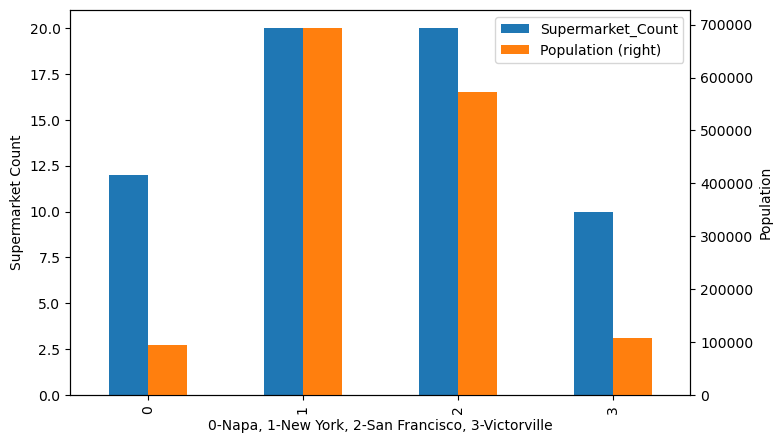

In [18]:
# Plot bar chart for supermarket count by population per city
final_two.plot(kind= 'bar' , secondary_y= 'Population', figsize=(8,5))
ax1, ax2 = plt.gcf().get_axes()
ax1.set_ylabel('Supermarket Count')
ax2.set_ylabel('Population')
ax1.set_xlabel('0-Napa, 1-New York, 2-San Francisco, 3-Victorville')

# Display bar chart
plt.show()

In [19]:
# Format and aggregate total poverty count by city
poverty_total = supermarkets_density_final.groupby(["City"])["Poverty Count"].sum().reset_index()

# Display dataframe
poverty_total

,City,Poverty Count
0,Napa,7097.0
1,New York,165005.0
2,San Francisco,56718.0
3,Victorville,19052.0


In [20]:
# Merge final two and poverty total dataframes on City
final_three = pd.merge(
    final_two,
    poverty_total,
    how = "left",
    on = ["City", "City"]
)

# Display dataframe
final_three

,City,Supermarket_Count,Population,Poverty Count
0,Napa,12,94258.0,7097.0
1,New York,20,693522.0,165005.0
2,San Francisco,20,571917.0,56718.0
3,Victorville,10,108430.0,19052.0


In [21]:
# Calculate the poverty percentage rate for each city
poverty_percentage_rate = (final_three["Poverty Count"]/final_three["Population"]) * 100

In [22]:
# Add columns for poverty percentage rate and customers per store to the dataframe
final_three["Poverty percentage rate"] = poverty_percentage_rate

# Display dataframe
final_three

,City,Supermarket_Count,Population,Poverty Count,Poverty percentage rate
0,Napa,12,94258.0,7097.0,7.529334
1,New York,20,693522.0,165005.0,23.792324
2,San Francisco,20,571917.0,56718.0,9.917173
3,Victorville,10,108430.0,19052.0,17.570783
